In [97]:
import pandas as pd
# 출력물의 생략없이 모두 출력
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

import re
import os 
import pickle

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
# font_path = "D:/project/fonts/NanumGothic.ttf"
# font_path = 'G:/다른 컴퓨터/My_desktop/project/fonts/NanumGothic.ttf'
# 한글 폰트 설정
font_path = 'G:/다른 컴퓨터/내 컴퓨터/project/fonts/NanumGothic.ttf'
# font_path = 'C:/project/fonts/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

### 파일 불러오기

In [98]:
ds = pd.read_excel("G:/다른 컴퓨터/내 컴퓨터/project/23년 공익데이터 실험실 2기/데이터전처리//[공익중개사] column_descriptions_0825.xlsx")
# ds = pd.read_excel("C:/project/23년 공익데이터 실험실 2기/데이터전처리//[공익중개사] column_descriptions_0825.xlsx")
ds.head()

,No,Column K name,meta,Data Type,Data Descriptions,Column Descriptions
0,1,작성자,C,category,NaN,NaN
1,2,구역,C,category,NaN,NaN
2,3,No,C,category,NaN,NaN
3,4,비고,C,str,NaN,NaN
4,5,지번주소,P,str,NaN,NaN


In [99]:
# 파일 경로 설정
file_path = 'G:/다른 컴퓨터/내 컴퓨터/project/23년 공익데이터 실험실 2기/데이터전처리/0904_위험지수_소유자구분_시군_나이.csv'
# file_path = 'C:/project/23년 공익데이터 실험실 2기/데이터전처리/0904_위험지수_소유자구분_시군_나이.csv'

df = pd.read_csv(file_path, encoding='cp949')
df_col = df.columns
print(df.head())


   작성자  구역   No                                  비고                   지번주소  \
0   나기   6  317                                 NaN  서울특별시 관악구 신림동 251-148   
1   나기   6   74                                 NaN  서울특별시 관악구 신림동 251-485   
2   세모   6  108  철근콘크리트조 평스라브지붕 5층 다중주택 및제2종 근린생활시설   서울특별시 관악구 신림동 251-40   
3  이하경   5   75                                 NaN   서울특별시 관악구 신림동 254-65   
4   공터   6  287                                 NaN  서울특별시 관악구 신림동 251-221   

                   도로명주소         위도          경도 대장구분        주용도  \
0      서울특별시 관악구 대학길 127  37.465312  126.938443   일반       단독주택   
1     서울특별시 관악구 대학길 97-6  37.466218  126.937889   일반       단독주택   
2  서울특별시 관악구 신림로11길 62-3  37.467602  126.938564   일반       단독주택   
3     서울특별시 관악구 대학12길 73  37.465073  126.935247   일반  제1종근린생활시설   
4   서울특별시 관악구 신림로11길 130  37.464856  126.939660   일반       단독주택   

            기타용도    건물명  대지면적(㎡)  건축면적(㎡)  건폐율(%)  연면적(㎡)  용적률산정연면적(㎡)  \
0  다가구용단독주택(5가구)   정보없음      0.0     0.00    0.00  361

### DATA 

In [100]:
# 'meta'의 종류 확인
unique_meta = ds['meta'].dropna().unique()
unique_meta


array(['C', 'P', 'G', 'E', 'O'], dtype=object)

In [101]:
# 메타 별로 묶은 컬럼 목록을 저장할 딕셔너리
meta_grouped_columns = {meta: [] for meta in unique_meta}

# 컬럼의 데이터 타입을 변경할 딕셔너리
dtype_conversion = {}

# 메타 별로 컬럼을 묶고, 데이터 타입을 설정
for index, row in ds.iterrows():
    meta = row['meta']
    column_name = row['Column K name']
    data_type = row['Data Type']
    
    if pd.notna(meta) and pd.notna(column_name):
        meta_grouped_columns[meta].append(column_name)
    
    if pd.notna(column_name) and pd.notna(data_type):
        if data_type == 'category':
            dtype_conversion[column_name] = 'category'
        elif data_type == 'str':
            dtype_conversion[column_name] = 'str'
        elif data_type == 'int':
            dtype_conversion[column_name] = 'int64'
        elif data_type == 'float':
            dtype_conversion[column_name] = 'float'
        elif data_type == 'date':
            dtype_conversion[column_name] = 'datetime64'

In [102]:
# 데이터 타입 'datetime64'을 'datetime64[ns]'로 변경
for column, dtype in dtype_conversion.items():
    if dtype == 'datetime64':
        dtype_conversion[column] = 'datetime64[ns]'

# 데이터 타입 변경
try:
    df = df.astype(dtype_conversion)
    dtype_change_success = True
except Exception as e:
    dtype_change_success = False
    error_message = str(e)

# 데이터 타입 변경이 성공했는지와 변경된 데이터 타입을 반환
dtype_change_success, df.dtypes.head() if dtype_change_success else error_message


(False,
 '"Only a column name can be used for the key in a dtype mappings argument. \'채권최고액\\n근저당권자\' not found in columns."')

In [103]:
# 정수로 변환해야 하는 컬럼을 찾아 결측치 확인
integer_columns = [col for col, dtype in dtype_conversion.items() if dtype == 'int64']
missing_integer_columns = [col for col in integer_columns if df[col].isna().any()]

# 결측치가 있는 정수형 컬럼에 대해 데이터 타입을 'Int64'로 변경
for col in missing_integer_columns:
    dtype_conversion[col] = 'Int64'

# 다시 데이터 타입 변경을 시도
try:
    df = df.astype(dtype_conversion)
    dtype_change_success = True
except Exception as e:
    dtype_change_success = False
    error_message = str(e)

# 데이터 타입 변경이 성공했는지와 변경된 데이터 타입을 반환
dtype_change_success, df.dtypes.head() if dtype_change_success else error_message


(False,
 '"Only a column name can be used for the key in a dtype mappings argument. \'채권최고액\\n근저당권자\' not found in columns."')

In [104]:
# 메타 별로 묶은 컬럼 목록을 출력
meta_grouped_columns


{'C': ['작성자', '구역', 'No', '비고'],
 'P': ['지번주소',
  '도로명주소',
  '위도',
  '경도',
  '대장구분',
  '주용도',
  '기타용도',
  '건물명',
  '대지면적(㎡)',
  '건축면적(㎡)',
  '건폐율(%)',
  '연면적(㎡)',
  '용적률산정연면적(㎡)',
  '용적률(%)',
  '구조',
  '지붕구조',
  '세대수(세대)',
  '가구수(가구)',
  '높이(m)',
  '지상층수',
  '지하층수',
  '총동연면적(㎡)',
  '허가일',
  '사용승인일',
  '옥탑여부'],
 'G': ['가등기',
  '가등기말소',
  '신탁',
  '신탁말소',
  '압류',
  '압류말소',
  '가압류',
  '가압류말소',
  '경매개시',
  '경매말소',
  '소유권이전등기가처분',
  '소유권이전등기가처분말소',
  '위험지수'],
 'E': ['근저당권설정',
  '채권총액',
  '제3금융권채권여부',
  '개인채권여부',
  '채권최고액',
  '채권최고액채무자이름',
  '채권최고액채무자유형',
  '채권최고액\n근저당권자',
  '현재전세권',
  '전세금(원)',
  '말소포함임차권유무',
  '현재집주인과임차권의관련성',
  '임차권최종말소여부',
  '매매가(원)'],
 'O': ['집지분소유자수(명)',
  '소유자(공유자)-1유형',
  '소유자(공유자)-1이름',
  '소유자(공유자)-1지분(%)',
  '소유자(공유자)-1주소',
  '소유자1위도',
  '소유자1경도',
  '소유자(공유자)-1실거주',
  '소유자(공유자)1생년월일',
  '소유자(공유자)1나이',
  '2번째공유자유형',
  '2번째공유자이름',
  '2번째공유자지분(%)',
  '2번째공유자주소',
  '2번째공유자실거주',
  '2번째공유자생년월일',
  '2번째공유자나이',
  '3번째공유자유형',
  '3번째공유자이름',
  '3번째공유자지분(%)',
  '3번째공유자주소',
  '3

## P

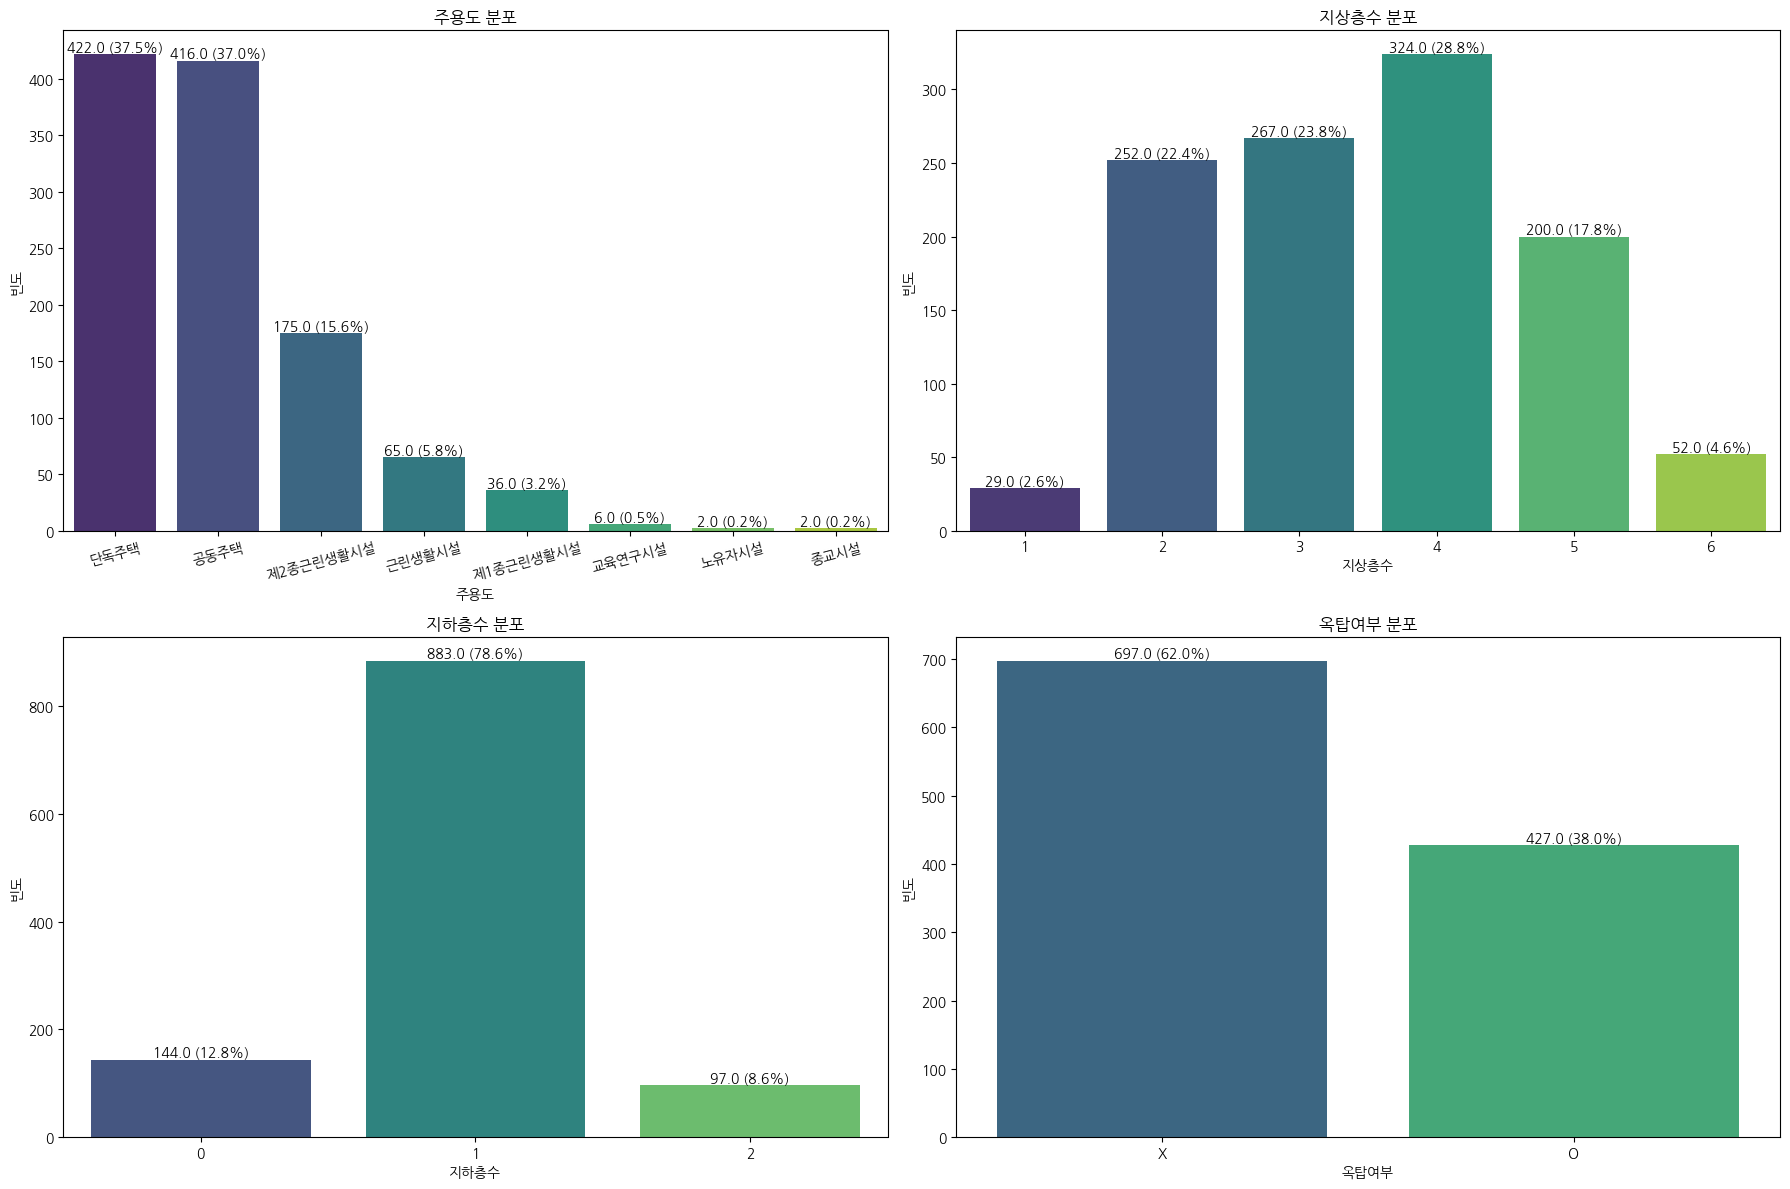

In [105]:
# Updated list of columns to visualize (removed '대장구분')
columns_to_visualize_2 = ['주용도', '지상층수', '지하층수', '옥탑여부']

# Initialize a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each column to visualize
for i, col in enumerate(columns_to_visualize_2):
    ax = axes[i]
    
    # Count the occurrences and sort the index if numeric
    value_counts = df[col].value_counts()
    if pd.api.types.is_numeric_dtype(df[col]):
        value_counts = value_counts.sort_index()
    
    # Calculate percentages for each category
    total_count = len(df)
    percentages = (value_counts / total_count * 100).round(1)
    
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='viridis')
    ax.set_title(f'{col} 분포')
    ax.set_xlabel(col)
    ax.set_ylabel('빈도')
    
    # Rotate x-axis labels for '주용도'
    if col == '주용도':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    
    # Add labels to each bar
    for j, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height()} ({percentages.iloc[j]:.1f}%)", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


## G

In [106]:
# 조건에 따라 값을 변환하는 함수
def convert_value(value):
    if value == 'O':
        return 7
    elif value == 'N':
        return 0
    elif value == 'X':
        return 3
    else:
        return value  # 값이 O, N, X가 아닌 경우 그대로 반환

# 변환할 컬럼 목록
convert_columns = ['가등기말소', '신탁말소', '압류말소', '가압류말소', '경매말소', '소유권이전등기가처분말소']

# 각 컬럼에 대하여 값 변환 진행
for column in convert_columns:
    df[column] = df[column].apply(convert_value)

# '위험지수' 컬럼 계산
df['위험지수'] = (df['가등기'] * df['가등기말소'] +
              df['신탁'] * df['신탁말소'] +
              df['압류'] * df['압류말소'] +
              df['가압류'] * df['가압류말소'] +
              df['경매개시'] * df['경매말소'] +
              df['소유권이전등기가처분'] * df['소유권이전등기가처분말소'])

df[['가등기', '가등기말소', '신탁', '신탁말소', '압류', '압류말소', '가압류', '가압류말소', '경매개시', '경매말소', '소유권이전등기가처분', '소유권이전등기가처분말소', '위험지수']].head()


,가등기,가등기말소,신탁,신탁말소,압류,압류말소,가압류,가압류말소,경매개시,경매말소,소유권이전등기가처분,소유권이전등기가처분말소,위험지수
0,1,7,0,0,1,7,1,7.0,0,0,0,0,21.0
1,0,0,0,0,1,7,0,0.0,0,0,0,0,7.0
2,0,0,0,0,2,7,0,0.0,0,0,0,0,14.0
3,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0
4,0,0,0,0,2,7,0,0.0,0,0,0,0,14.0


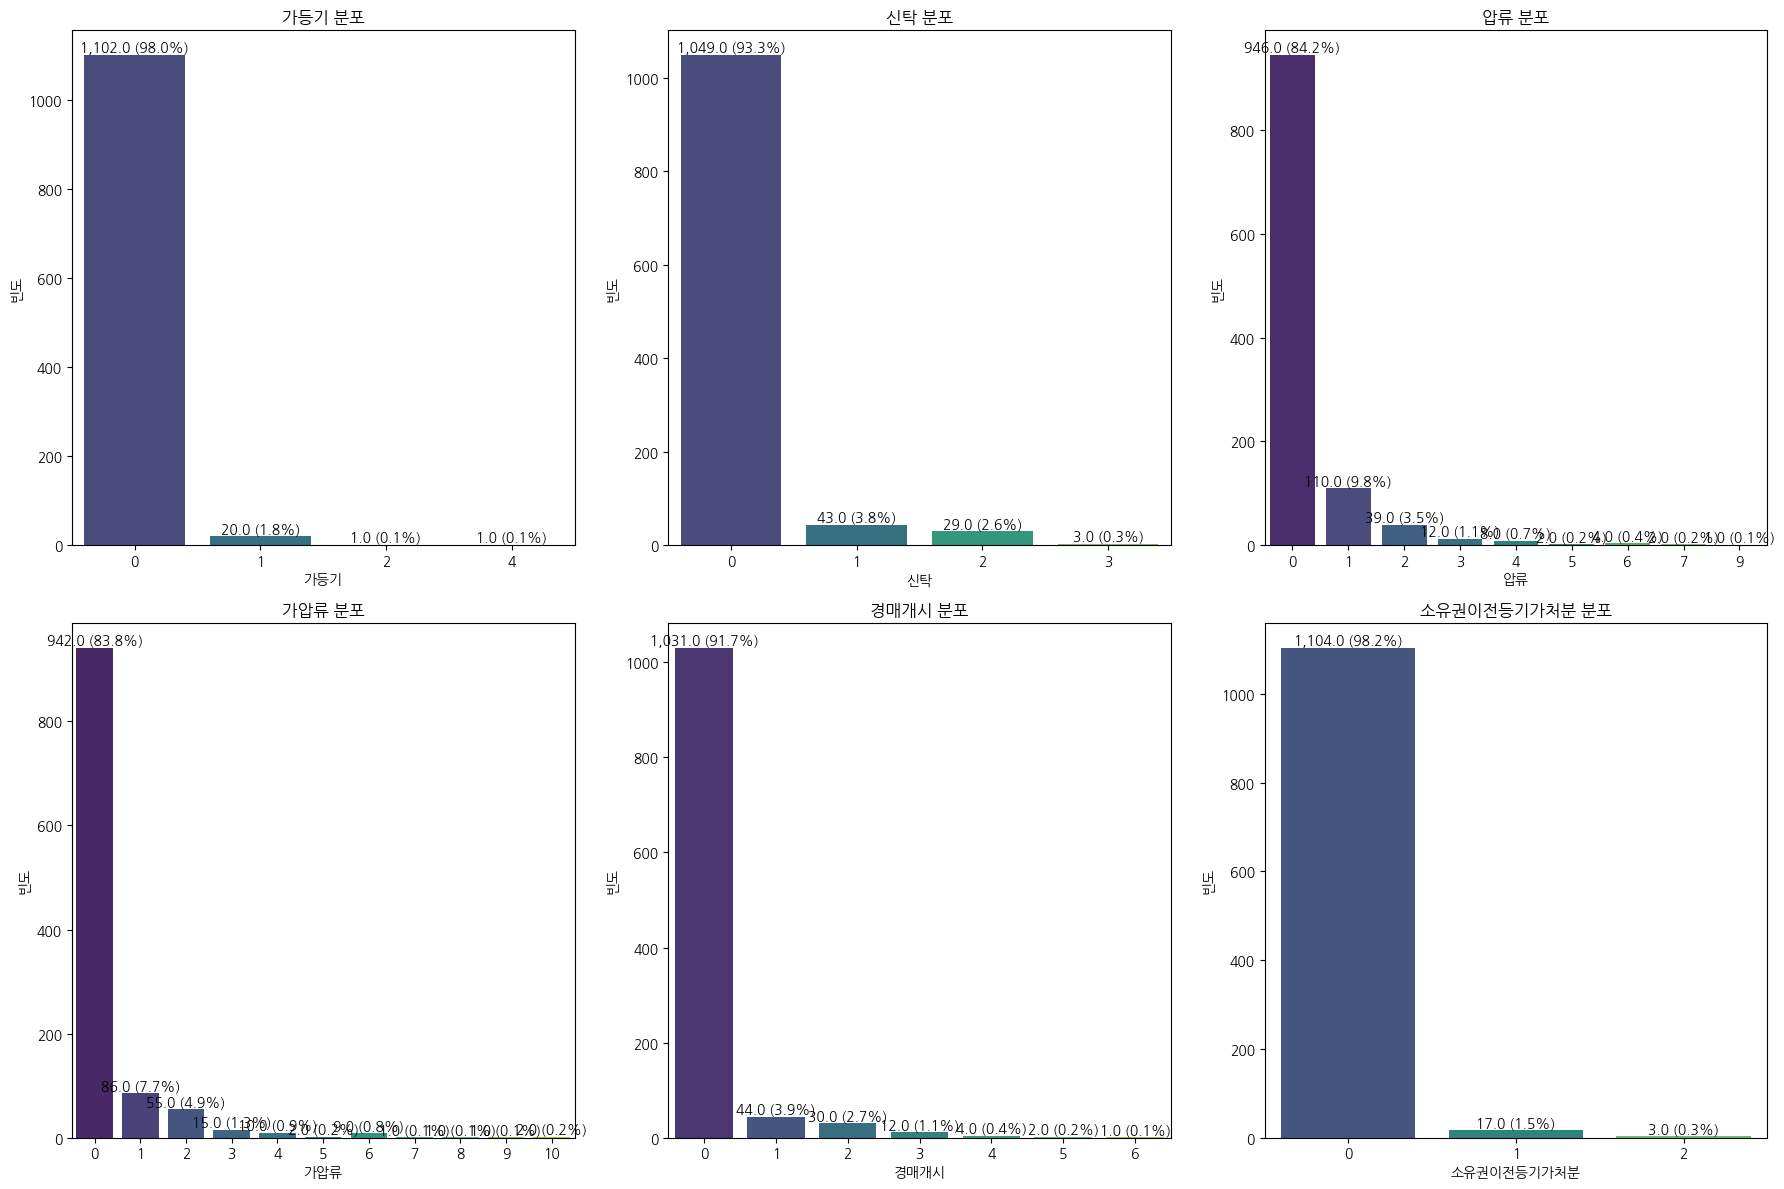

In [107]:
# 시각화할 열 목록
columns_to_visualize = ['가등기', '신탁', '압류', '가압류', '경매개시', '소유권이전등기가처분']

# 2x3 서브플롯 그리드 초기화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 배열을 일렬로 펼쳐 인덱싱을 쉽게 함
axes = axes.flatten()

# 각 열을 시각화하는 루프
for i, col in enumerate(columns_to_visualize):
    ax = axes[i]
    sns.countplot(data=df, x=col, ax=ax, palette='viridis', order=sorted(df[col].unique()))
    ax.set_title(f'{col} 분포')
    ax.set_xlabel(col)
    ax.set_ylabel('빈도')
    
    # 각 막대 위에 정수 값 및 백분율 추가
    total = len(df[col])
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:,} ({height / total * 100:.1f}%)",
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


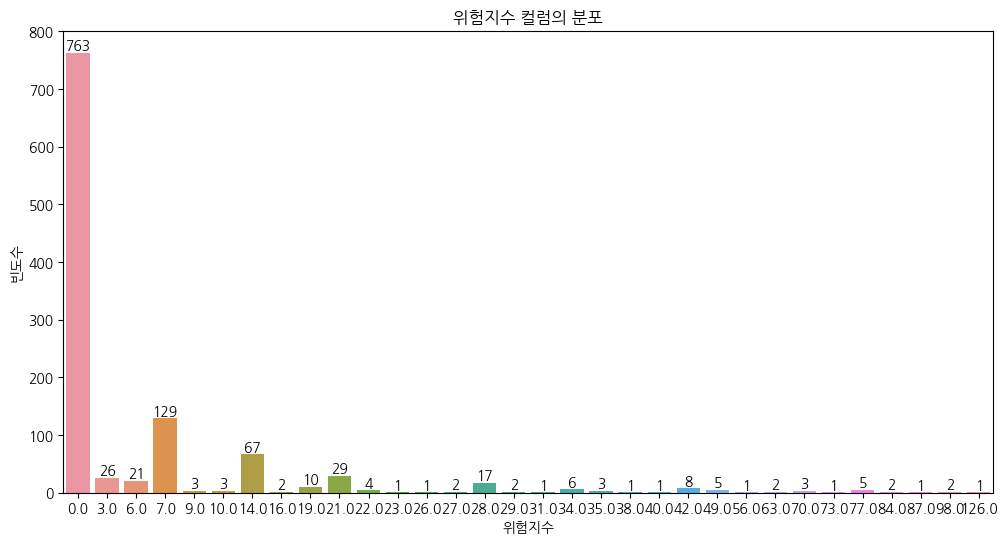

In [108]:
# 위험지수 컬럼의 분포를 시각화
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='위험지수')

# 데이터 레이블 표시
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 0.2, int(height), 
                   ha="center", va='bottom')

plt.title('위험지수 컬럼의 분포')
plt.xlabel('위험지수')
plt.ylabel('빈도수')
plt.show()


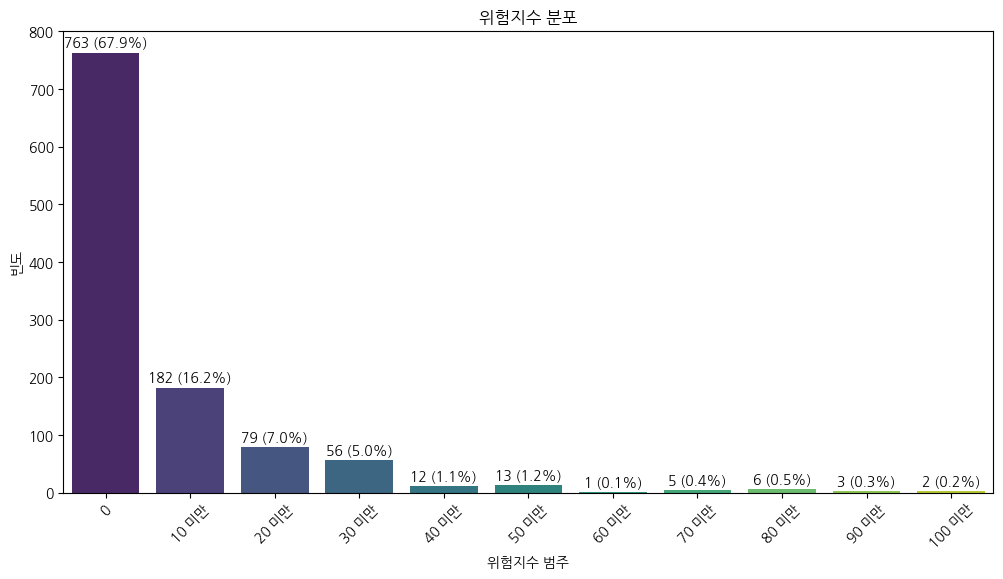

In [109]:
# 전체 데이터의 개수를 계산
total_count = len(df)

# 각 범주가 차지하는 비율을 계산
risk_value_ratio = (risk_value_counts / total_count * 100).round(1)

# seaborn을 사용하여 시각화
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=risk_value_counts.index, y=risk_value_counts.values, palette='viridis')
plt.title('위험지수 분포')
plt.xlabel('위험지수 범주')
plt.ylabel('빈도')
plt.xticks(rotation=45)

# 빈도 값과 비율을 위에 레이블로 추가
for i, (v, r) in enumerate(zip(risk_value_counts, risk_value_ratio)):
    label = f"{v:,} ({r}%)"
    ax.text(i, v + 5, label, ha='center', va='bottom')

plt.show()


## E

In [110]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

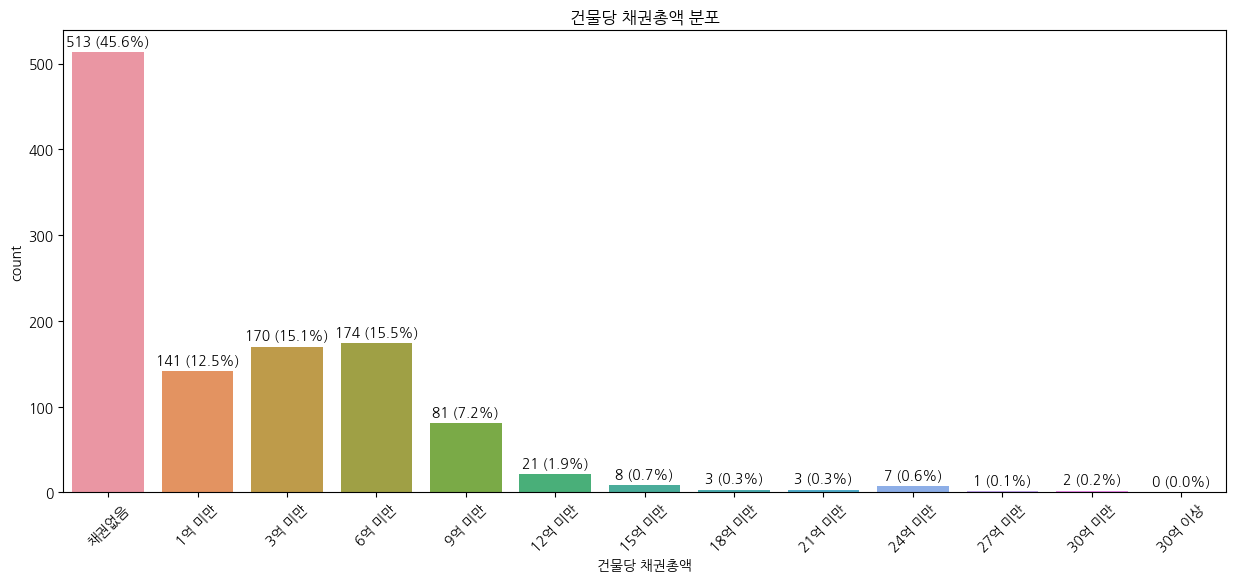

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# 새로운 범주와 라벨 설정
new_bins = [-1, 0, 1e8, 3e8, 6e8, 9e8, 12e8, 15e8, 18e8, 21e8, 24e8, 27e8, 30e8, float('inf')]
new_labels = ['채권없음', '1억 미만', '3억 미만', '6억 미만', '9억 미만', '12억 미만', '15억 미만', '18억 미만', '21억 미만', '24억 미만', '27억 미만', '30억 미만', '30억 이상']

# 데이터프레임에 새로운 범주 열 추가
df['채권총액_새범주'] = pd.cut(df['채권총액'], bins=new_bins, labels=new_labels)

# 새로운 범주별 빈도 계산
new_value_counts = df['채권총액_새범주'].value_counts().sort_index()

# seaborn을 사용하여 막대 그래프 그리기
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=new_value_counts.index, y=new_value_counts.values)
plt.title('건물당 채권총액 분포')
plt.xlabel('건물당 채권총액')
plt.ylabel('count')
plt.xticks(rotation=45)

# 각 막대 위에 정수 값 및 백분율 추가
total_count = len(df)
for i, v in enumerate(new_value_counts):
    percentage = (v / total_count * 100)
    ax.text(i, v + 5, f"{v:,} ({percentage:.1f}%)", ha='center', va='bottom')

plt.show()


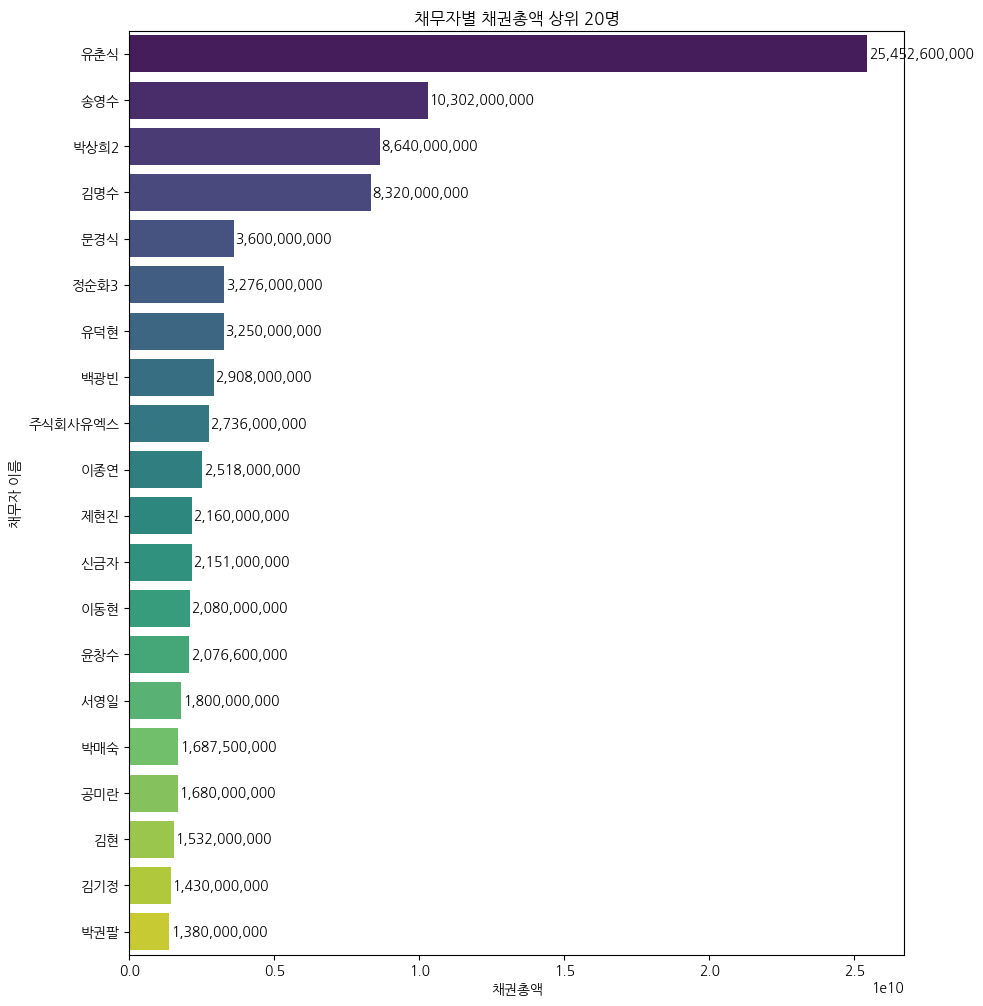

In [112]:
import seaborn as sns

# '채권총액'을 '채권최고액채무자이름'으로 집계
grouped_data = df.groupby('채권최고액채무자이름')['채권총액'].sum().reset_index()

# 집계된 데이터를 내림차순으로 정렬하고 상위 30개 선택
top_20_debtors = grouped_data.sort_values(by='채권총액', ascending=False).head(20)

# seaborn을 사용하여 시각화
plt.figure(figsize=(10, 12))
ax = sns.barplot(data=top_20_debtors, y='채권최고액채무자이름', x='채권총액', palette='viridis')
plt.title('채무자별 채권총액 상위 20명')
plt.xlabel('채권총액')
plt.ylabel('채무자 이름')

# 채무자 이름 위에 채권총액 값을 표시
for i, v in enumerate(top_20_debtors['채권총액']):
    ax.text(v + 50000000, i, f'{v:,}', va='center')

plt.show()


In [113]:
# '채권최고액채무자이름'을 기준으로 '채권총액'을 집계하고, 상위 30명을 선택
top_15_debtors = grouped_data.sort_values(by='채권총액', ascending=False).head(15)
top_15_debtors

,채권최고액채무자이름,채권총액
280,유춘식,25452600000
221,송영수,10302000000
169,박상희2,8640000000
51,김명수,8320000000
152,문경식,3600000000
406,정순화3,3276000000
273,유덕현,3250000000
203,백광빈,2908000000
434,주식회사유엑스,2736000000
354,이종연,2518000000


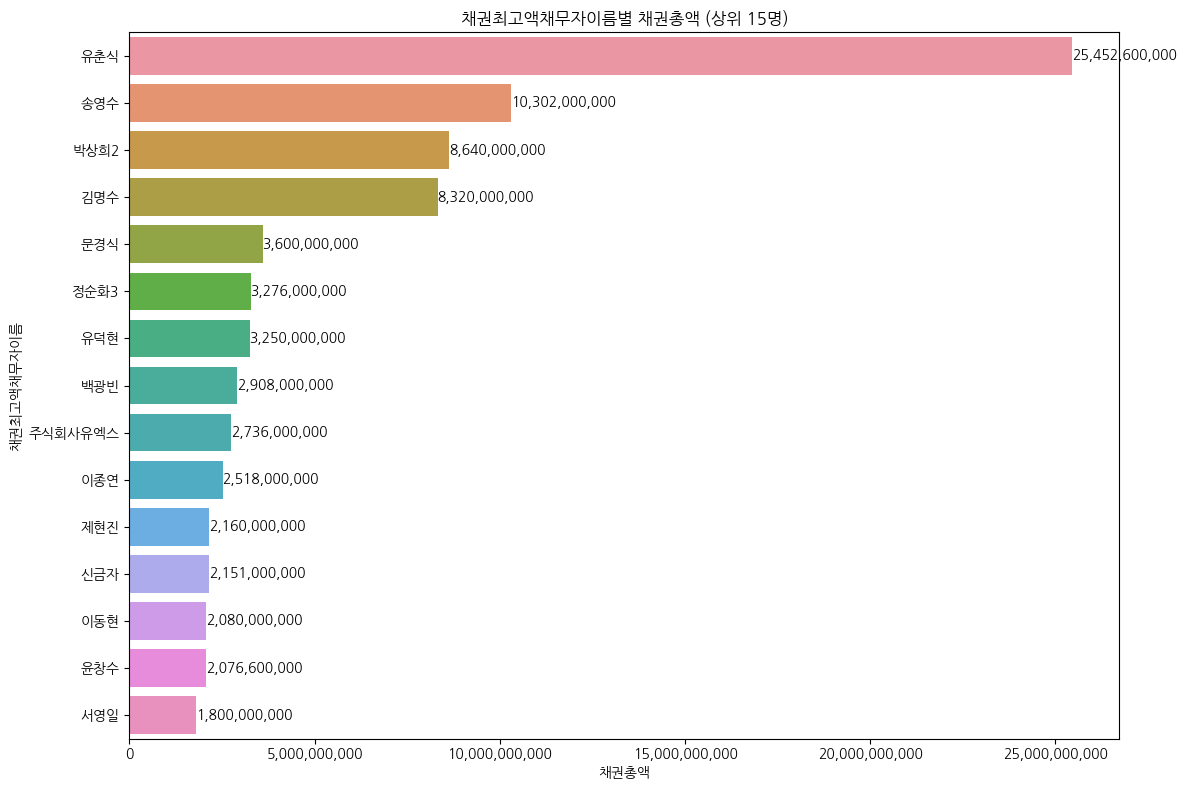

In [114]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='채권총액', y='채권최고액채무자이름', data=top_15_debtors, orient='h', linewidth=0.5)  # linewidth 조절
ax.set_title('채권최고액채무자이름별 채권총액 (상위 15명)')

# label 추가
for p in ax.patches:
    ax.annotate(f"{p.get_width():,.0f}", (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center')

# x축 간격 조절
plt.xticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))  # 정수 포맷팅 설정
plt.tight_layout()
plt.show()


### 유춘식과 위험지수

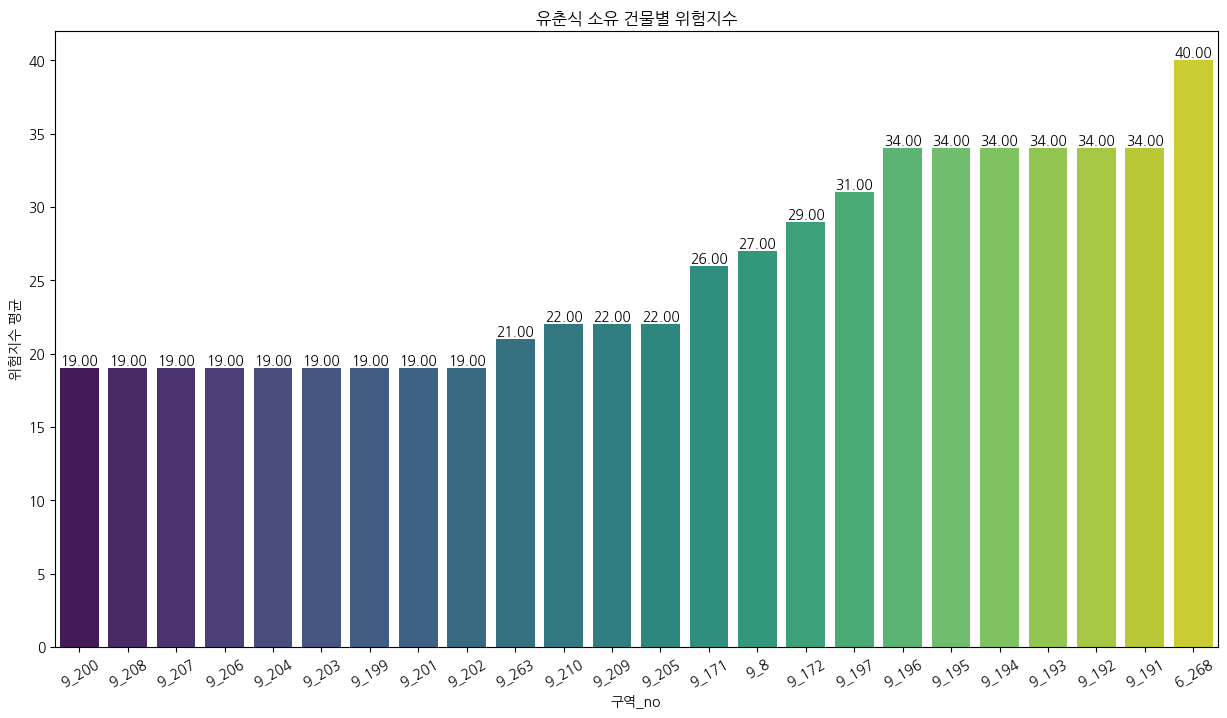

In [115]:
# seaborn을 사용하여 시각화
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=yoo_chunsik_counts, x='구역_no', y='위험지수', palette='viridis')
plt.title('유춘식 소유 건물별 위험지수')
plt.xlabel('구역_no')
plt.ylabel('위험지수 평균')
plt.xticks(rotation=30)  # x축 레이블 회전 설정

# 위험지수 평균 값 위에 텍스트로 표시
for i, v in enumerate(yoo_chunsik_counts['위험지수']):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()


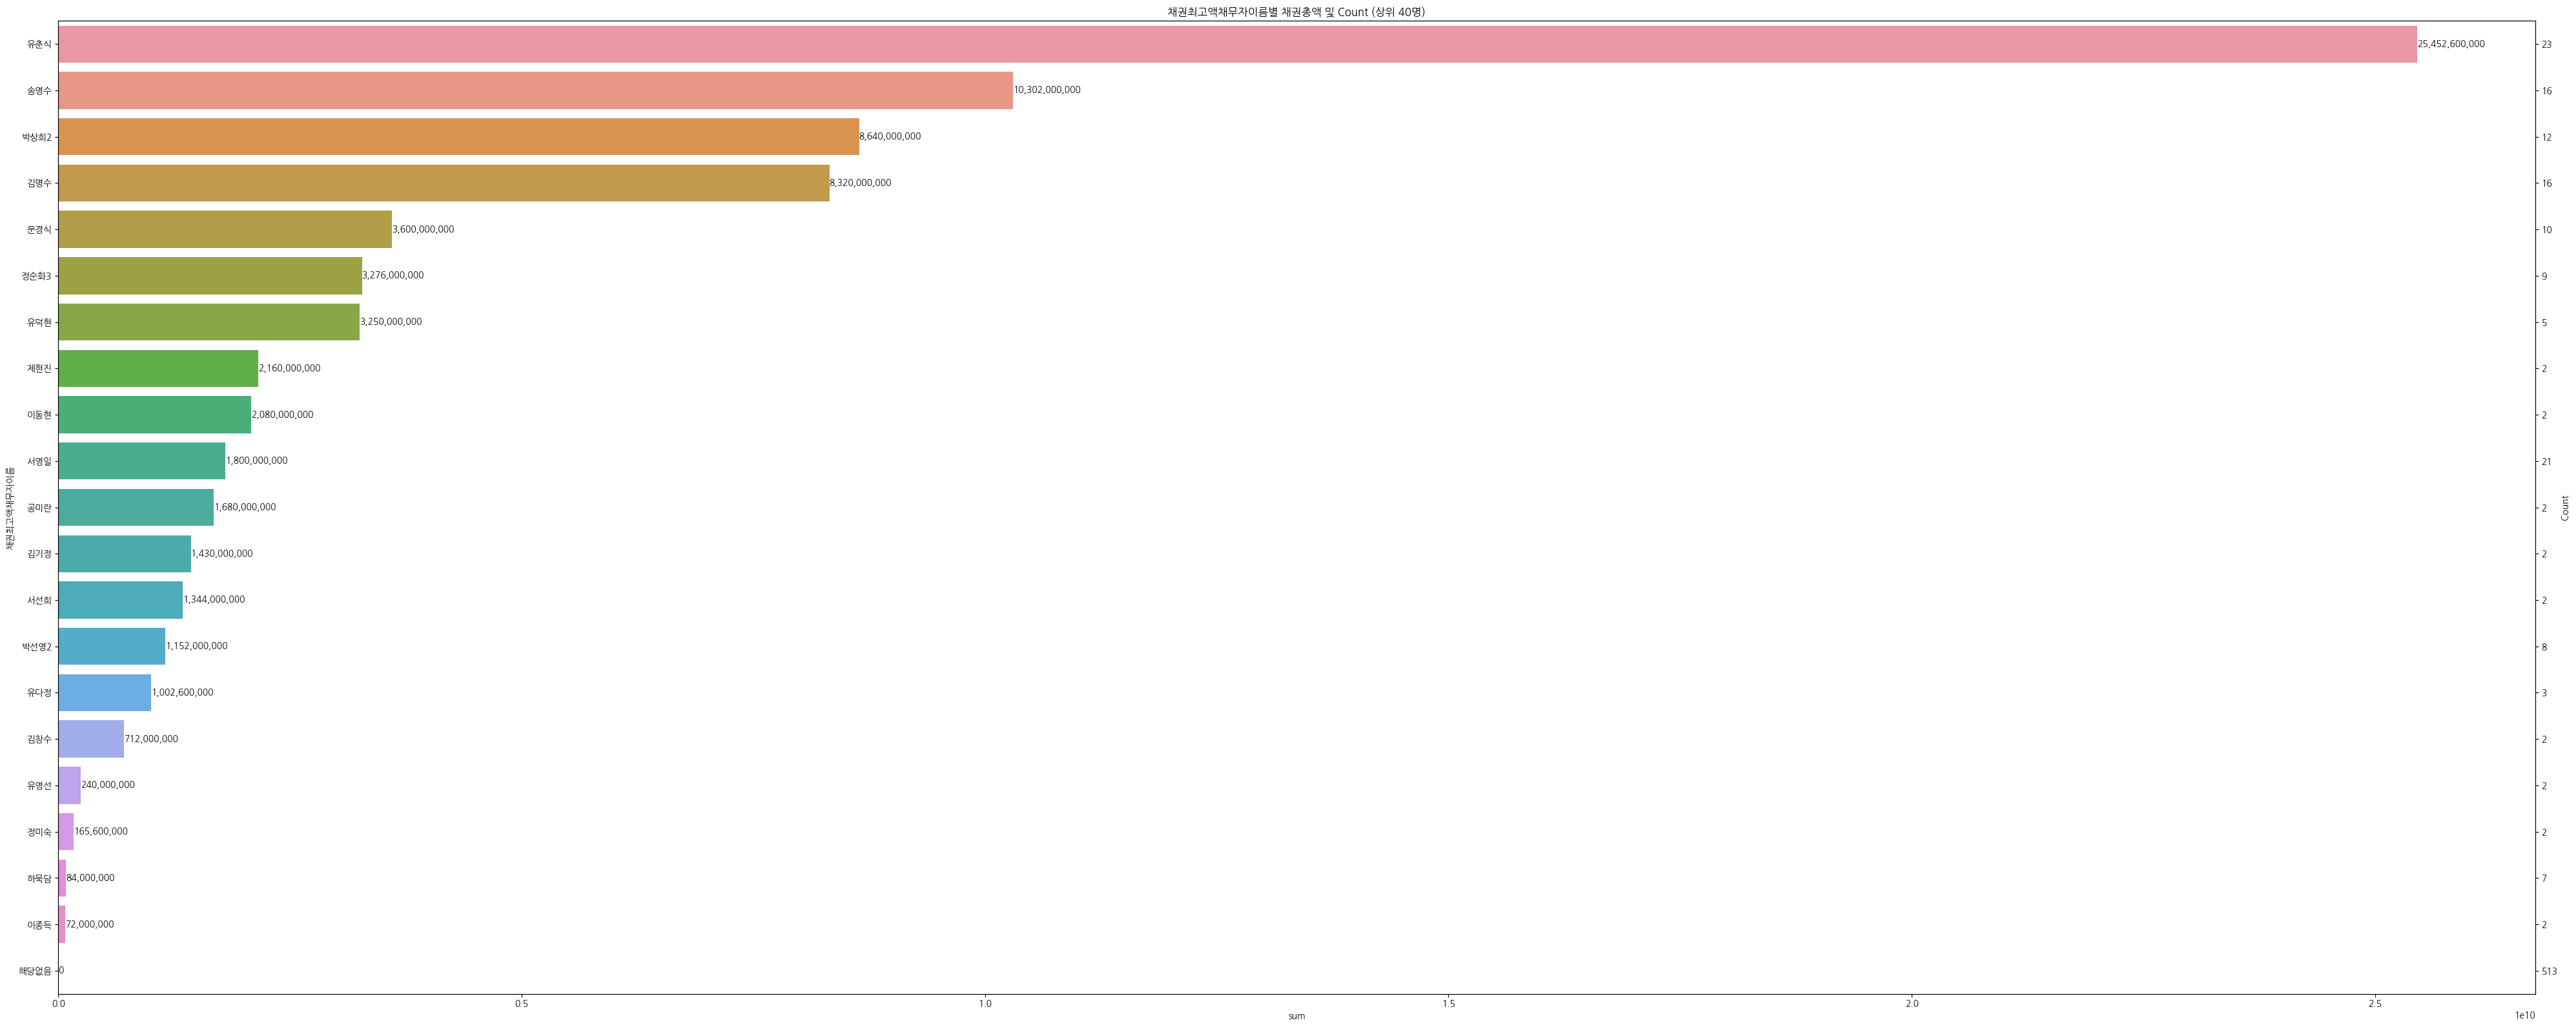

In [116]:
# '채권최고액채무자이름'을 기준으로 '채권총액'을 집계하고, count가 1 초과인 조건
total_debt_by_debtor = df.groupby('채권최고액채무자이름')['채권총액'].agg(['sum', 'count']).reset_index()
total_debt_by_debtor_filtered = total_debt_by_debtor[total_debt_by_debtor['count'] > 1]

# '채권총액'이 높은 순서대로 상위 40명을 선택
top_40_debtors = total_debt_by_debtor_filtered.nlargest(40, 'sum')

# 시각화
fig, ax1 = plt.subplots(figsize=(40, 16))

# '채권총액'에 대한 바 차트
sns.barplot(x='sum', y='채권최고액채무자이름', data=top_40_debtors, ax=ax1, orient='h')

# 라벨 추가
for p in ax1.patches:
    ax1.annotate(f"{p.get_width():,.0f}", (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center')

# 두 번째 y축 추가 (Count 표시)
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(top_40_debtors['count'])
ax2.set_ylabel('Count')

# 그래프 타이틀과 레전드 설정
ax1.set_title('채권최고액채무자이름별 채권총액 및 Count (상위 40명)')

plt.tight_layout()
plt.show()


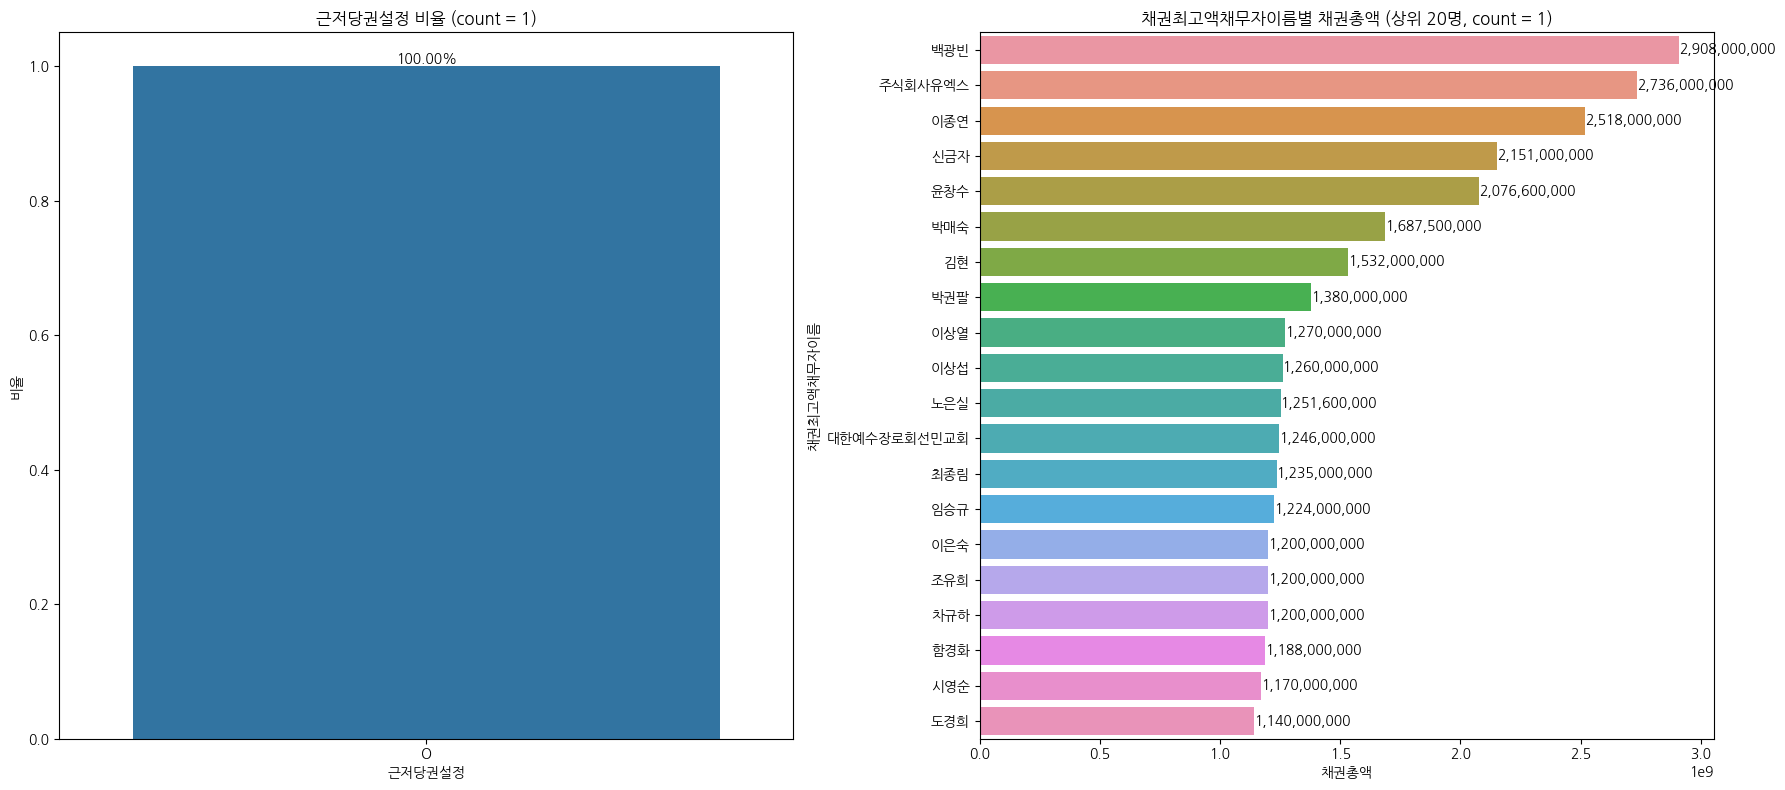

In [117]:
# '채권최고액채무자이름'에서 count 값이 1인 것들만 변수로 저장
single_count_debtors = total_debt_by_debtor[total_debt_by_debtor['count'] == 1]
filtered_single_count_data = df[df['채권최고액채무자이름'].isin(single_count_debtors['채권최고액채무자이름'])]

# 해당 변수에서 '근저당권설정' 값의 비율 계산
single_mortgage_ratio = filtered_single_count_data['근저당권설정'].value_counts(normalize=True).reset_index()
single_mortgage_ratio.columns = ['근저당권설정', '비율']

# '채권최고액채무자이름' 값 별로 '채권총액' 값을 sum해서 높은 순서대로 정렬합니다.
single_sum_debt_by_debtor = filtered_single_count_data.groupby('채권최고액채무자이름')['채권총액'].sum().reset_index()
single_top_debtors_by_sum = single_sum_debt_by_debtor.nlargest(20, '채권총액')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# '근저당권설정' 값의 비율 시각화
sns.barplot(x='근저당권설정', y='비율', data=single_mortgage_ratio, ax=axes[0])
axes[0].set_title('근저당권설정 비율 (count = 1)')

# 라벨 추가
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

# '채권최고액채무자이름' 값 별로 '채권총액' 값을 sum해서 높은 순서대로 시각화
sns.barplot(x='채권총액', y='채권최고액채무자이름', data=single_top_debtors_by_sum, ax=axes[1], orient='h')
axes[1].set_title('채권최고액채무자이름별 채권총액 (상위 20명, count = 1)')

# 라벨 추가
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_width():,.0f}", (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center')

plt.tight_layout()
plt.show()


## 소유자

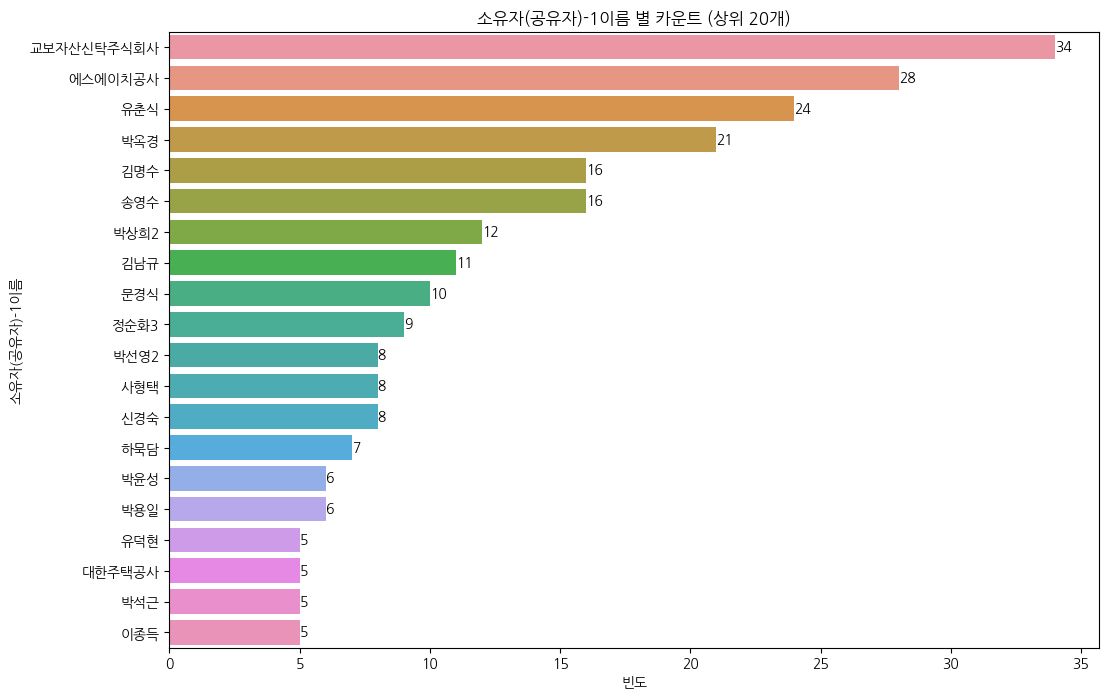

In [118]:
owner_counts = df["소유자(공유자)-1이름"].value_counts()

top_20_owner_counts = owner_counts.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_owner_counts.values, y=top_20_owner_counts.index)
plt.title("소유자(공유자)-1이름 별 카운트 (상위 20개)")
plt.xlabel("빈도")
plt.ylabel("소유자(공유자)-1이름")

# 라벨 추가 시작
for i, count in enumerate(top_20_owner_counts.values):
    plt.text(count, i, str(count), va='center')
# 라벨 추가 종료

plt.show()


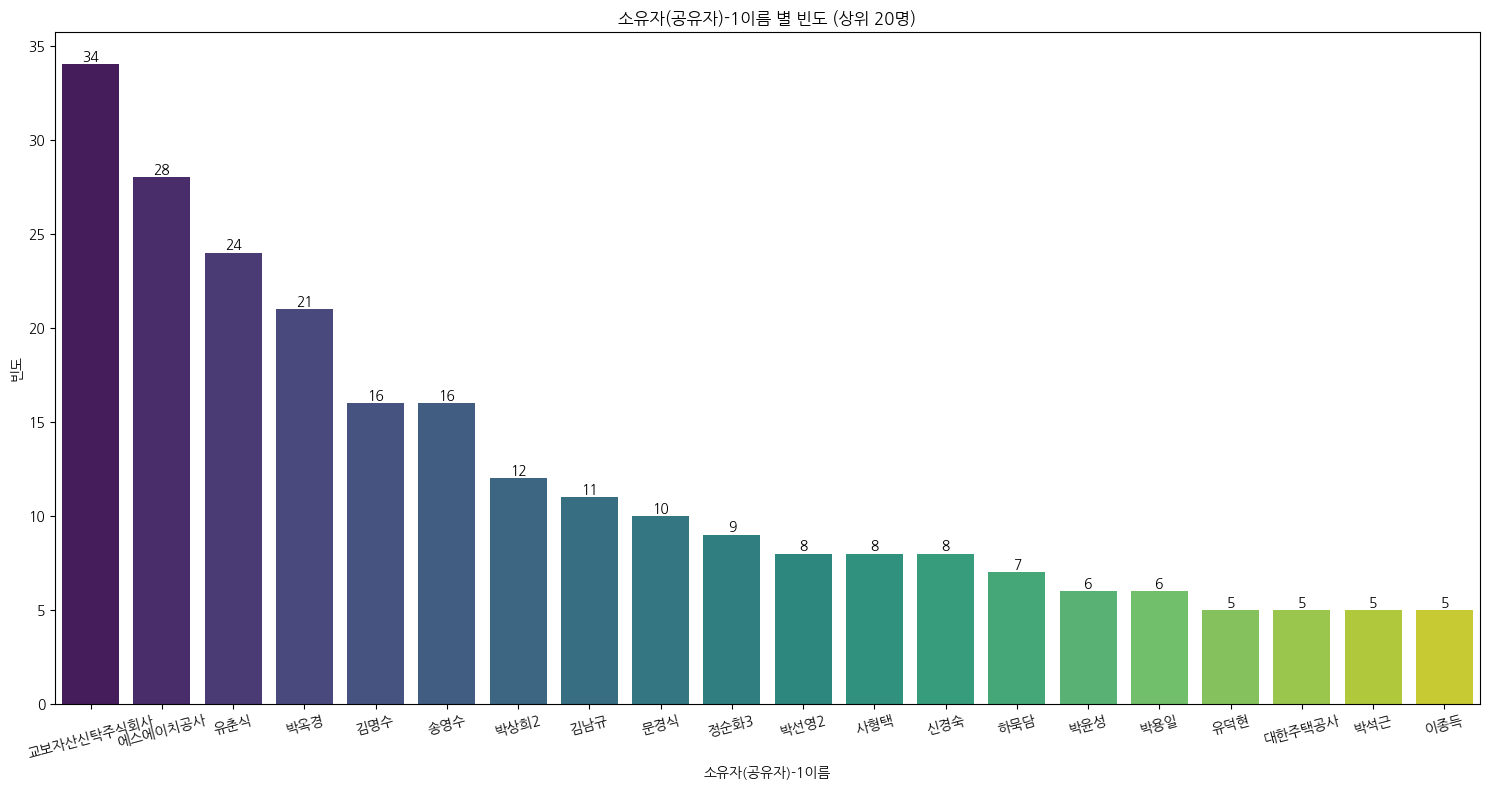

In [126]:
# '소유자(공유자)-1이름' 열의 각 이름의 빈도 계산
owner_name_counts = df['소유자(공유자)-1이름'].value_counts()

# 시각화를 위해 상위 20개의 가장 빈도가 높은 이름 선택
top_20_owner_names = owner_name_counts.nlargest(20)

# seaborn을 사용하여 시각화
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=top_20_owner_names.index, y=top_20_owner_names.values, palette='viridis')
plt.title('소유자(공유자)-1이름 별 빈도 (상위 20명)')
plt.xlabel('소유자(공유자)-1이름')
plt.ylabel('빈도')
plt.xticks(rotation=15)

# 각 막대 위에 레이블 추가 (정수로 표시)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()


# O


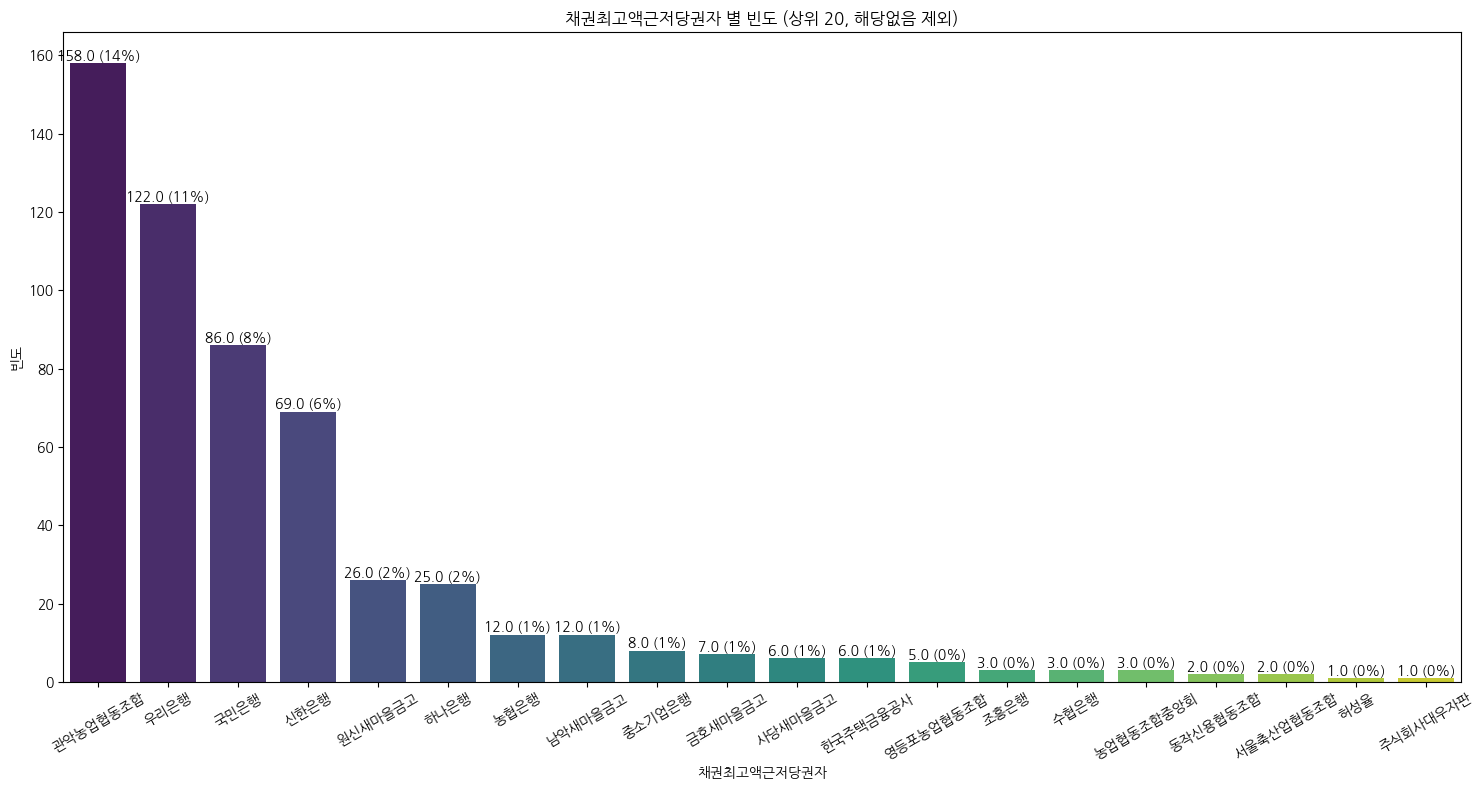

In [127]:
# '채권최고액근저당권자' 열의 각 값의 빈도 계산
creditor_counts = df['채권최고액근저당권자'].value_counts()

# '해당없음' 값을 제외하여 상위 20개의 가장 빈도가 높은 값 선택
top_20_creditors = creditor_counts[creditor_counts.index != '해당없음'].nlargest(20)

# 각 카테고리별 백분율 계산 (정수로 표시)
total_count = len(df)
percentages = (top_20_creditors / total_count * 100).round(0).astype(int)

# seaborn을 사용하여 시각화
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=top_20_creditors.index, y=top_20_creditors.values, palette='viridis')
plt.title('채권최고액근저당권자 별 빈도 (상위 20, 해당없음 제외)')
plt.xlabel('채권최고액근저당권자')
plt.ylabel('빈도')
plt.xticks(rotation=30)

# 각 막대 위에 레이블 추가 (빈도와 백분율 표시)
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height()} ({percentages.iloc[i]}%)", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()


In [121]:
# '소유자(공유자)-1주소' 컬럼에서 첫 번째 스페이스바 앞의 단어만 추출하여 '시군' 컬럼 생성
df['시군'] = df['소유자(공유자)-1주소'].str.split(' ').str[0]

# 결과 확인
df[['소유자(공유자)-1주소', '시군']].head()


,소유자(공유자)-1주소,시군
0,경기도 용인시 수지구 상현동 840 상현마을금호베스트빌4단지 133-1902,경기도
1,서울특별시 관악구 관악로 304 101동703호,서울특별시
2,"서울특별시 관악구 관악로 304, 101동703호(봉천동,관악현대아파트)",서울특별시
3,서울특별시 관악구 신림동 254-65,서울특별시
4,"경기도 부천시 경인로10번길 25-32, 103동",경기도


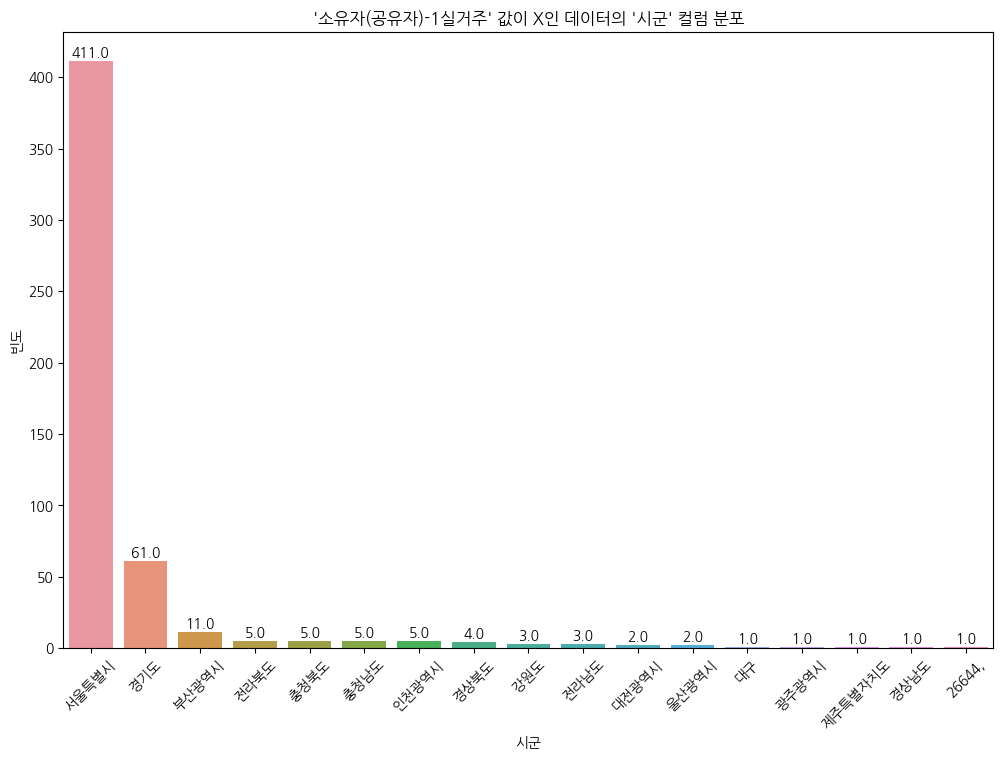

In [122]:
# '소유자(공유자)-1실거주' 값이 'X'이고 '법인'이 아닌 데이터만 필터링
filtered_df = df[(df['소유자(공유자)-1실거주'] == 'X') & (df['시군'] != '법인')]

# 필터링된 데이터에서 '시군' 컬럼의 값별 빈도를 계산
filtered_value_counts = filtered_df['시군'].value_counts()

# 전체 필터링된 데이터 개수
filtered_total_count = len(filtered_df)

# 그래프 그리기
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=filtered_value_counts.index, y=filtered_value_counts.values)

# 라벨과 수치값 추가
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{}'.format(height),  # 백분율 대신 수치값 표시
            ha="center")

plt.xticks(rotation=45)
plt.title("'소유자(공유자)-1실거주' 값이 X인 데이터의 '시군' 컬럼 분포")
plt.xlabel("시군")
plt.ylabel("빈도")
plt.show()


### 나이

C:\Users\user\AppData\Local\Temp\ipykernel_19000\1222289517.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_age_df['연령대'] = pd.cut(filtered_age_df['소유자(공유자)1나이'], bins=bins, labels=labels, right=False)


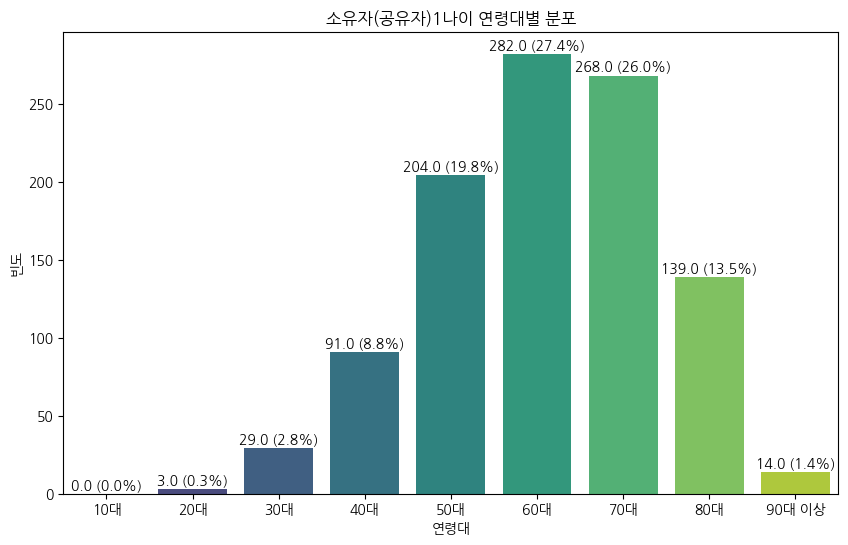

In [123]:
# '소유자(공유자)1나이' 컬럼에서 값이 0인 행을 제외
filtered_age_df = df[df['소유자(공유자)1나이'] > 0]

# 연령대 별로 분류
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 1000]
labels = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대 이상']
filtered_age_df['연령대'] = pd.cut(filtered_age_df['소유자(공유자)1나이'], bins=bins, labels=labels, right=False)

# 'SettingWithCopyWarning' 경고를 피하기 위해 .copy() 사용
filtered_age_df = df[df['소유자(공유자)1나이'] > 0].copy()

# 연령대 별로 분류
filtered_age_df['연령대'] = pd.cut(filtered_age_df['소유자(공유자)1나이'], bins=bins, labels=labels, right=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=filtered_age_df, x='연령대', order=labels, palette='viridis')
plt.title('소유자(공유자)1나이 연령대별 분포')
plt.xlabel('연령대')
plt.ylabel('빈도')

# 라벨과 퍼센티지 추가
filtered_age_total_count = len(filtered_age_df)
for p in ax.patches:
    height = p.get_height()
    label = f"{height} ({(height/filtered_age_total_count)*100:1.1f}%)"
    ax.text(p.get_x() + p.get_width()/2., height + 3, label, ha="center")

plt.show()


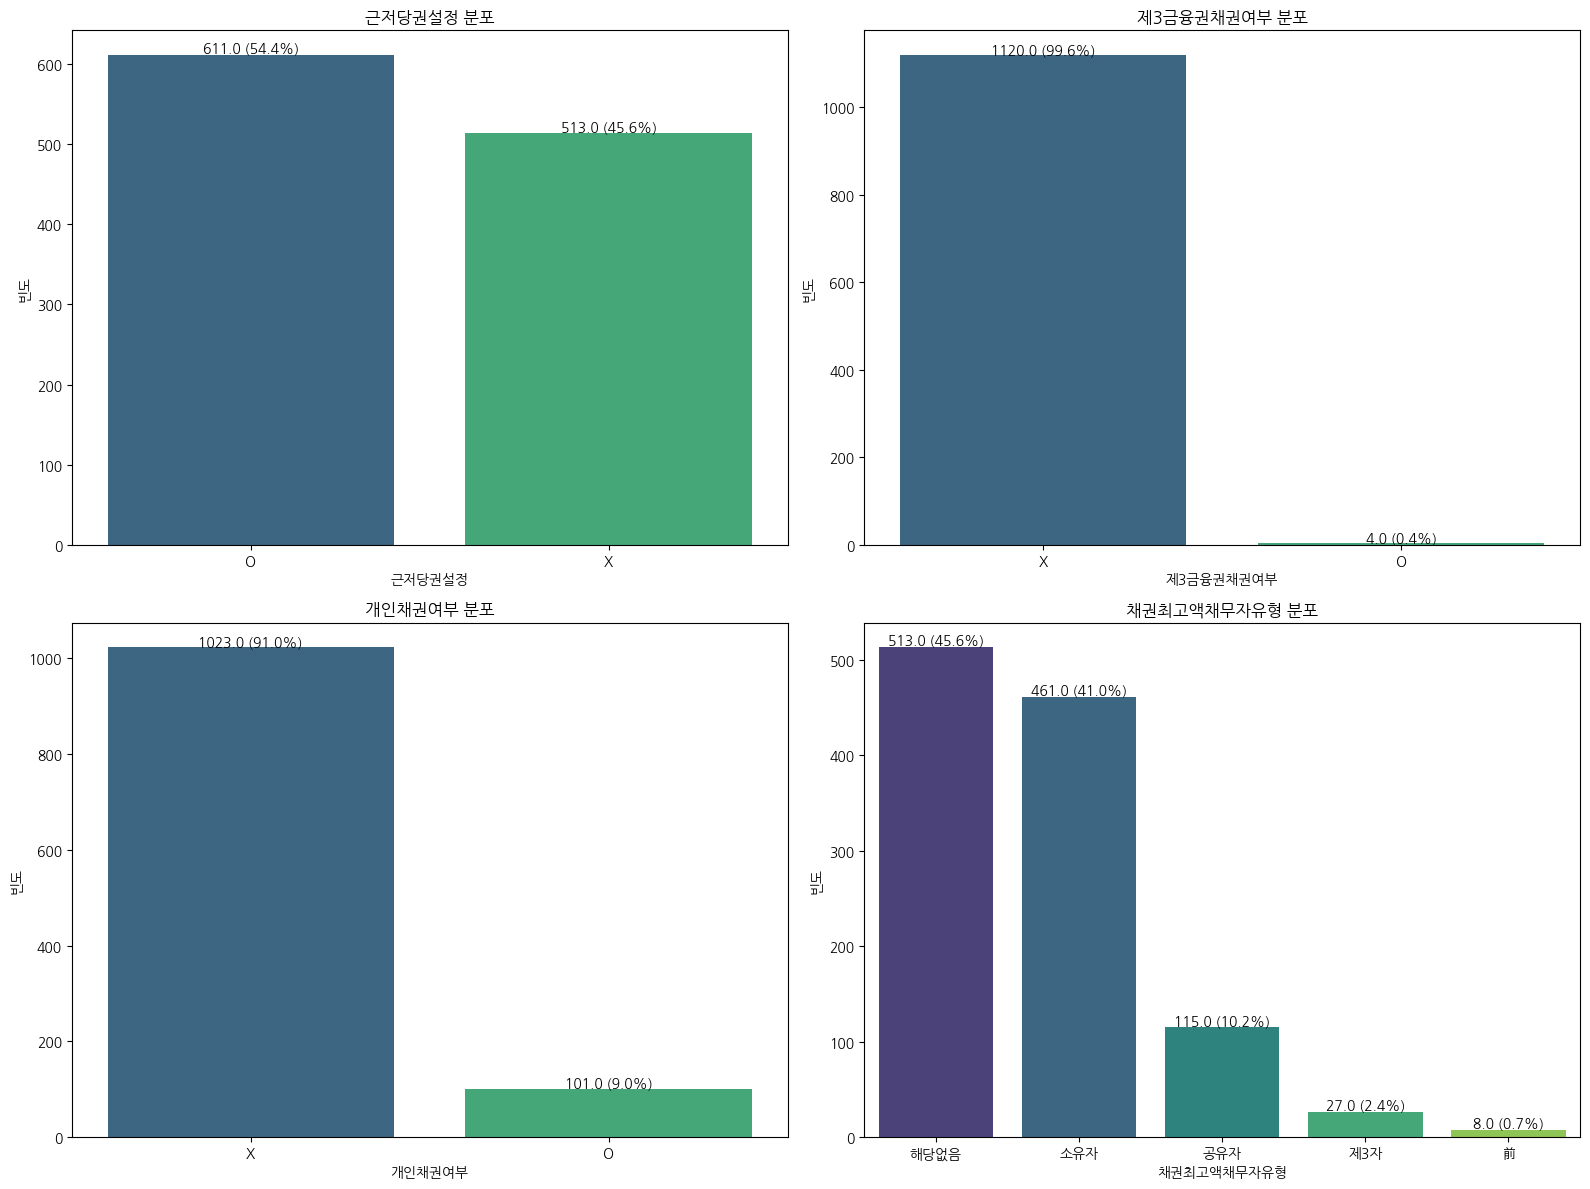

In [124]:
# 컬럼 리스트
columns_to_visualize = ['근저당권설정', '제3금융권채권여부', '개인채권여부', '채권최고액채무자유형']

# 그래프 그리기
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(columns_to_visualize):
    ax = axes[idx]
    value_counts = df[col].value_counts()
    total_count = len(df)
    
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='viridis')
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                f"{height} ({height/total_count:.1%})",
                ha="center")
        
    ax.set_title(f"{col} 분포")
    ax.set_xlabel(col)
    ax.set_ylabel("빈도")

plt.tight_layout()
plt.show()


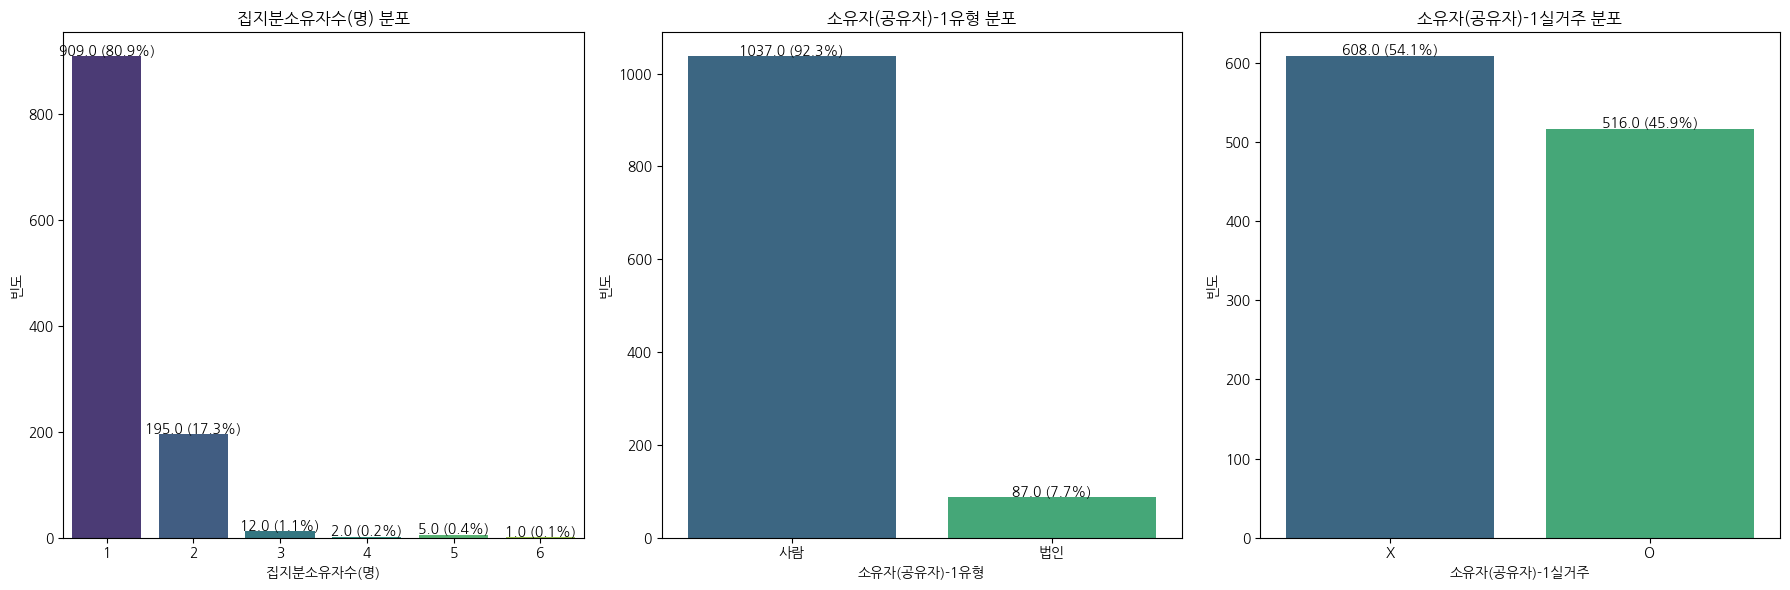

In [125]:
# 컬럼 리스트
columns_to_visualize_3 = ['집지분소유자수(명)', '소유자(공유자)-1유형', '소유자(공유자)-1실거주']

# 1*3 형태의 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for idx, col in enumerate(columns_to_visualize_3):
    ax = axes[idx]
    value_counts = df[col].value_counts()
    total_count = len(df)
    
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette='viridis')
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                f"{height} ({height/total_count:.1%})",
                ha="center")
        
    ax.set_title(f"{col} 분포")
    ax.set_xlabel(col)
    ax.set_ylabel("빈도")

plt.tight_layout()
plt.show()
